#### Imports

In [408]:
from mpi4py import MPI
from petsc4py import PETSc

import numpy as np
from scipy.sparse import csr_matrix

import ufl
from basix.ufl import element, mixed_element
from dolfinx import fem, la, plot
from dolfinx.fem import (
    Constant,
    Function,
    dirichletbc,
    extract_function_spaces,
    form,
    functionspace,
    locate_dofs_topological,
)
from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
from dolfinx.io import XDMFFile
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import div, dx, grad, inner

import matplotlib.pyplot as plt

import tt
from tt import cross

#### Parameters

In [409]:
rng = np.random.default_rng()

n_sinker = 2
delta = rng.uniform(10, 200, n_sinker)
omega = 0.0
beta = 10
# c = np.random.rand(n_sinker,2)
c = np.array([[0.2, 0.3],[0.6,0.7]])

DR = 100
mu_min = 1 / np.sqrt(DR)
mu_max = np.sqrt(DR)


def chi(x, centers, deltas):
  res = np.ones(x.shape[1])
  for i in range(n_sinker):
    res *= 1 - np.exp(-deltas[i] * np.square(np.maximum(0, np.linalg.norm(x[:2] - centers[i].reshape(-1,1), axis = 0) - 0.5 * omega)))
  
  return res

def viscosity_expr(x, centers=c, deltas=delta):
  """Viscosity field"""
  return (mu_max - mu_min) * (1 - chi(x, centers, deltas)) + mu_min

def f_expr(x, centers=c, deltas=delta):
  return np.vstack([np.zeros(x.shape[1]), beta * (chi(x, centers, deltas) - 1)])

In [410]:
# Create mesh
msh = create_rectangle(
    MPI.COMM_WORLD, [np.array([0, 0]), np.array([1, 1])], [32, 32], CellType.triangle
)

# Function to mark x = 0, x = 1, y = 0 and y = 1 (all boundary) 
def noslip_boundary(x):
    # return np.logical_or(
    #     np.logical_or(np.isclose(x[0], 0.0), np.isclose(x[0], 1.0)), 
    #     np.isclose(x[1], 0.0), np.isclose(x[1], 2.0)
    # )
    return np.full(x.shape[1], True)

P2 = element("Lagrange", msh.basix_cell(), 2, shape=(msh.geometry.dim,))
P1 = element("Lagrange", msh.basix_cell(), 1)
V, Q = functionspace(msh, P2), functionspace(msh, P1)

# No-slip condition on boundaries 
noslip = np.zeros(msh.geometry.dim, dtype=PETSc.ScalarType)  # type: ignore
facets = locate_entities_boundary(msh, 1, noslip_boundary)
bc0 = dirichletbc(noslip, locate_dofs_topological(V, 1, facets), V)

# Collect Dirichlet boundary conditions
bcs = [bc0]

# Define variational problem
(u, p) = ufl.TrialFunction(V), ufl.TrialFunction(Q)
(v, q) = ufl.TestFunction(V), ufl.TestFunction(Q)
f = fem.Function(V)
f.interpolate(f_expr)

mu = fem.Function(Q)
mu.interpolate(viscosity_expr)

a = form([[mu * inner(grad(u), grad(v)) * dx, inner(p, div(v)) * dx], [inner(div(u), q) * dx, None]])
L = form([inner(f, v) * dx, inner(Constant(msh, PETSc.ScalarType(0)), q) * dx])  # type: ignore

# preconditioner
a_p11 = form(inner(p, q) * dx)
a_p = [[a[0][0], None], [None, a_p11]]


In [411]:
cells, cell_types, coords = plot.vtk_mesh(Q)

Ny = np.array(n_sinker * [10])
Nx = coords.shape[0]

def mu_func(x):
  res = np.empty(x.shape[0])
  for i, xi in enumerate(x):
    d = (190 * xi[1:] / (Ny-1) + 10).reshape(-1,1)
    res[i] = viscosity_expr(coords[xi[0]].reshape(-1,1), deltas=d)[0]
  
  return res

# random init tensor
C_mu = tt.rand(np.array([Nx] + Ny.tolist()),r=10)
# compute TT approx using TT-cross
C_mu = tt.cross.rect_cross.cross(mu_func, C_mu, nswp=5, eps = 1e-5, kickrank=5)
C_mu = C_mu.round(1e-12)

print("Coefficient ranks: ", C_mu.r)
print("Coefficient dims: ", C_mu.n)

In [412]:
np.sum([C_mu.r[i] * C_mu.n[i] * C_mu.r[i+1] for i in range(len(C_mu.n))])

268250

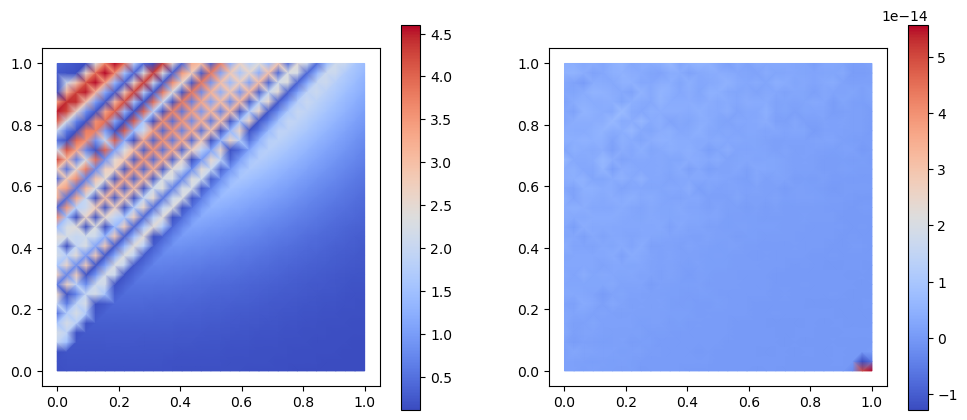

In [413]:
y = np.random.randint(0, Ny)

y_real = (190 * y / (Ny-1) + 10).reshape(-1,2)

mu_plot = fem.Function(Q)
C_error = np.empty(mu_plot.x.array.shape[0])

for i in range(mu_plot.x.array.shape[0]):
  mu_plot.x.array[i] = C_mu[np.array([i] + y.tolist())]
  C_error[i] = mu_plot.x.array[i]
  C_error[i] -= mu_func(np.array([[i] + y.tolist()]))[0]

cells, cell_types, x = plot.vtk_mesh(Q)

fig, axs = plt.subplots(1,2, figsize=(12,5))

val = axs[0].tripcolor(x.T[0], x.T[1], mu_plot.x.array ,cmap='coolwarm', shading='gouraud')
cbar_val = fig.colorbar(val , ax=axs[0])
axs[0].set_aspect('equal')

error = axs[1].tripcolor(x.T[0], x.T[1], C_error ,cmap='coolwarm', shading='gouraud')
cbar_err = fig.colorbar(error , ax=axs[1])
axs[1].set_aspect('equal')

In [414]:
def block_operators():
    """Return block operators and block RHS vector for the Stokes
    problem"""

    # Assembler matrix operator, preconditioner and RHS vector into
    # single objects but preserving block structure
    A = assemble_matrix_block(a, bcs=bcs)
    A.assemble()
    P = assemble_matrix_block(a_p, bcs=bcs)
    P.assemble()
    b = assemble_vector_block(L, a, bcs=bcs)

    # Set the nullspace for pressure (since pressure is determined only
    # up to a constant)
    null_vec = A.createVecLeft()
    offset = V.dofmap.index_map.size_local * V.dofmap.index_map_bs
    null_vec.array[offset:] = 1.0
    null_vec.normalize()
    nsp = PETSc.NullSpace().create(vectors=[null_vec])
    assert nsp.test(A)
    A.setNullSpace(nsp)

    return A, P, b

def block_direct_solver():
    """Solve the Stokes problem using blocked matrices and a direct
    solver."""

    # Assembler the block operator and RHS vector
    A, _, b = block_operators()
    
    ai, aj, av = A.getValuesCSR()
    Asp = csr_matrix((av, aj, ai))
    print(Asp.shape)

    print(b.getArray().shape)

    # Create a solver
    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")

    # Set the solver type to MUMPS (LU solver) and configure MUMPS to
    # handle pressure nullspace
    pc = ksp.getPC()
    pc.setType("lu")
    pc.setFactorSolverType("mumps")
    try:
        pc.setFactorSetUpSolverType()
    except PETSc.Error as e:
        if e.ierr == 92:
            print("The required PETSc solver/preconditioner is not available. Exiting.")
            print(e)
            exit(0)
        else:
            raise e
    pc.getFactorMatrix().setMumpsIcntl(icntl=24, ival=1)  # For pressure nullspace
    pc.getFactorMatrix().setMumpsIcntl(icntl=25, ival=0)  # For pressure nullspace

    # Create a block vector (x) to store the full solution, and solve
    x = A.createVecLeft()
    ksp.solve(b, x)

    # Create Functions and scatter x solution
    u, p = Function(V), Function(Q)
    offset = V.dofmap.index_map.size_local * V.dofmap.index_map_bs
    u.x.array[:offset] = x.array_r[:offset]
    p.x.array[: (len(x.array_r) - offset)] = x.array_r[offset:]

    # Compute the $L^2$ norms of the u and p vectors
    norm_u, norm_p = u.x.norm(), p.x.norm()
    if MPI.COMM_WORLD.rank == 0:
        print(f"(C) Norm of velocity coefficient vector (blocked, direct): {norm_u}")
        print(f"(C) Norm of pressure coefficient vector (blocked, direct): {norm_p}")

    return u, p

In [415]:
def nested_iterative_solver():
    """Solve the Stokes problem using nest matrices and an iterative solver."""

    # Assemble nested matrix operators
    A = fem.petsc.assemble_matrix_nest(a, bcs=bcs)
    A.assemble()

    # Create a nested matrix P to use as the preconditioner. The
    # top-left block of P is shared with the top-left block of A. The
    # bottom-right diagonal entry is assembled from the form a_p11:
    P11 = fem.petsc.assemble_matrix(a_p11, [])
    P = PETSc.Mat().createNest([[A.getNestSubMatrix(0, 0), None], [None, P11]])
    P.assemble()

    A00 = A.getNestSubMatrix(0, 0)
    A00.setOption(PETSc.Mat.Option.SPD, True)

    P00, P11 = P.getNestSubMatrix(0, 0), P.getNestSubMatrix(1, 1)
    P00.setOption(PETSc.Mat.Option.SPD, True)
    P11.setOption(PETSc.Mat.Option.SPD, True)

    # Assemble right-hand side vector
    b = fem.petsc.assemble_vector_nest(L)

    # Modify ('lift') the RHS for Dirichlet boundary conditions
    fem.petsc.apply_lifting_nest(b, a, bcs=bcs)

    # Sum contributions for vector entries that are share across
    # parallel processes
    for b_sub in b.getNestSubVecs():
        b_sub.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS vector
    bcs0 = fem.bcs_by_block(extract_function_spaces(L), bcs)
    fem.petsc.set_bc_nest(b, bcs0)

    # The pressure field is determined only up to a constant. We supply
    # a vector that spans the nullspace to the solver, and any component
    # of the solution in this direction will be eliminated during the
    # solution process.
    null_vec = fem.petsc.create_vector_nest(L)

    # Set velocity part to zero and the pressure part to a non-zero
    # constant
    null_vecs = null_vec.getNestSubVecs()
    null_vecs[0].set(0.0), null_vecs[1].set(1.0)

    # Normalize the vector that spans the nullspace, create a nullspace
    # object, and attach it to the matrix
    null_vec.normalize()
    nsp = PETSc.NullSpace().create(vectors=[null_vec])
    assert nsp.test(A)
    A.setNullSpace(nsp)

    # Create a MINRES Krylov solver and a block-diagonal preconditioner
    # using PETSc's additive fieldsplit preconditioner
    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A, P)
    ksp.setType("minres")
    ksp.setTolerances(rtol=1e-9)
    ksp.getPC().setType("fieldsplit")
    ksp.getPC().setFieldSplitType(PETSc.PC.CompositeType.ADDITIVE)

    # Define the matrix blocks in the preconditioner with the velocity
    # and pressure matrix index sets
    nested_IS = P.getNestISs()
    ksp.getPC().setFieldSplitIS(("u", nested_IS[0][0]), ("p", nested_IS[0][1]))

    # Set the preconditioners for each block. For the top-left
    # Laplace-type operator we use algebraic multigrid. For the
    # lower-right block we use a Jacobi preconditioner. By default, GAMG
    # will infer the correct near-nullspace from the matrix block size.
    ksp_u, ksp_p = ksp.getPC().getFieldSplitSubKSP()
    ksp_u.setType("preonly")
    ksp_u.getPC().setType("gamg")
    ksp_p.setType("preonly")
    ksp_p.getPC().setType("jacobi")

    # Create finite element {py:class}`Function <dolfinx.fem.Function>`s
    # for the velocity (on the space `V`) and for the pressure (on the
    # space `Q`). The vectors for `u` and `p` are combined to form a
    # nested vector and the system is solved.
    u, p = Function(V), Function(Q)
    x = PETSc.Vec().createNest([la.create_petsc_vector_wrap(u.x), la.create_petsc_vector_wrap(p.x)])
    ksp.solve(b, x)

    # Compute norms of the solution vectors
    norm_u = u.x.norm()
    norm_p = p.x.norm()
    if MPI.COMM_WORLD.rank == 0:
        print(f"(A) Norm of velocity coefficient vector (nested, iterative): {norm_u}")
        print(f"(A) Norm of pressure coefficient vector (nested, iterative): {norm_p}")

    return u, p

In [416]:
def nested_direct_solver():
    """Solve the Stokes problem using nest matrices and an direct solver."""

    # Assemble nested matrix operators
    A = fem.petsc.assemble_matrix_nest(a, bcs=bcs)
    A.assemble()

    A00 = A.getNestSubMatrix(0, 0)
    ai, aj, av = A00.getValuesCSR()
    Asp = csr_matrix((av, aj, ai))
    print(Asp.shape)

    # Assemble right-hand side vector
    b = fem.petsc.assemble_vector_nest(L)
    bnp = b.getNestSubVecs()[0].getArray()
    print(bnp.shape)

    # Modify ('lift') the RHS for Dirichlet boundary conditions
    fem.petsc.apply_lifting_nest(b, a, bcs=bcs)

    # Sum contributions for vector entries that are share across
    # parallel processes
    for b_sub in b.getNestSubVecs():
        b_sub.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    # Set Dirichlet boundary condition values in the RHS vector
    bcs0 = fem.bcs_by_block(extract_function_spaces(L), bcs)
    fem.petsc.set_bc_nest(b, bcs0)

    # The pressure field is determined only up to a constant. We supply
    # a vector that spans the nullspace to the solver, and any component
    # of the solution in this direction will be eliminated during the
    # solution process.
    null_vec = fem.petsc.create_vector_nest(L)

    # Set velocity part to zero and the pressure part to a non-zero
    # constant
    null_vecs = null_vec.getNestSubVecs()
    null_vecs[0].set(0.0), null_vecs[1].set(1.0)

    # Normalize the vector that spans the nullspace, create a nullspace
    # object, and attach it to the matrix
    null_vec.normalize()
    nsp = PETSc.NullSpace().create(vectors=[null_vec])
    assert nsp.test(A)
    A.setNullSpace(nsp)

    # Create a solver
    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")
    
    # Set the solver type to MUMPS (LU solver) and configure MUMPS to
    # handle pressure nullspace
    pc = ksp.getPC()
    pc.setType("lu")
    pc.setFactorSolverType("mumps")
    try:
        pc.setFactorSetUpSolverType()
    except PETSc.Error as e:
        if e.ierr == 92:
            print("The required PETSc solver/preconditioner is not available. Exiting.")
            print(e)
            exit(0)
        else:
            raise e
    pc.getFactorMatrix().setMumpsIcntl(icntl=24, ival=1)  # For pressure nullspace
    pc.getFactorMatrix().setMumpsIcntl(icntl=25, ival=0)  # For pressure nullspace

    # Create finite element {py:class}`Function <dolfinx.fem.Function>`s
    # for the velocity (on the space `V`) and for the pressure (on the
    # space `Q`). The vectors for `u` and `p` are combined to form a
    # nested vector and the system is solved.
    u, p = Function(V), Function(Q)
    x = PETSc.Vec().createNest([la.create_petsc_vector_wrap(u.x), la.create_petsc_vector_wrap(p.x)])
    ksp.solve(b, x)

    # Compute norms of the solution vectors
    norm_u = u.x.norm()
    norm_p = p.x.norm()
    if MPI.COMM_WORLD.rank == 0:
        print(f"(A) Norm of velocity coefficient vector (nested, direct): {norm_u}")
        print(f"(A) Norm of pressure coefficient vector (nested, direct): {norm_p}")

    return u, p

In [417]:
# Solve using PETSc block matrices and an LU solver
uh, ph = block_direct_solver()

(9539, 9539)
(9539,)
(C) Norm of velocity coefficient vector (blocked, direct): 1.47985443330442
(C) Norm of pressure coefficient vector (blocked, direct): 24.612581815571566


In [418]:
uh, ph = nested_iterative_solver()

(A) Norm of velocity coefficient vector (nested, iterative): 1.4798544332738879
(A) Norm of pressure coefficient vector (nested, iterative): 24.612581815387976


In [419]:
uh, ph = nested_direct_solver()

(8450, 8450)
(8450,)
(A) Norm of velocity coefficient vector (nested, direct): 1.47985443330442
(A) Norm of pressure coefficient vector (nested, direct): 24.61258181557156


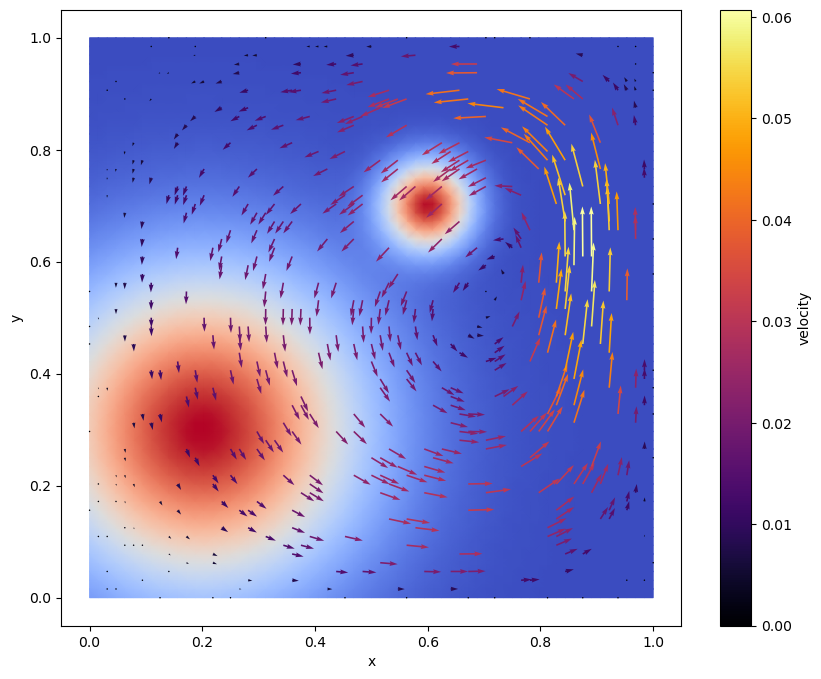

In [420]:
import matplotlib.pyplot as plt

cells, cell_types, x = plot.vtk_mesh(V)
N = x.shape[0]

fig, ax = plt.subplots(figsize=(10,8))

viscosity = viscosity_expr(x.T)

ax.tripcolor(x.T[0], x.T[1], viscosity,cmap='coolwarm', shading='gouraud')

# random decimate points
rng = np.random.default_rng()
mask = rng.uniform(size = N) < (500 / N)
vec = uh.x.array.reshape(N, V.dofmap.index_map_bs)[mask]
velocity = ax.quiver(x[mask,0] , x[mask,1], vec[:,0,], vec[:,1], np.linalg.norm(vec, axis=1),
                     cmap='inferno')

cbar = fig.colorbar(velocity, ax=ax)

ax.set_xlabel('x')
ax.set_ylabel('y')
cbar.set_label('velocity')